# Introduction

Clustering algorithms are unsupervised methods for finding groups of data points that have similar representations in a feature space. Clustering differs from classification in that no a priori labeling (grouping) of the data points is available.
K-means clustering is a simple and popular clustering algorithm. Given a set of points in multifimentional space, it tries to find K clusters such that each data point belongs to exactly one cluster, and that the sum of the squares of the distances between each data point and the center of the cluster it belongs to is minimized. 

Approach of K-means algorithm is to repeatedly perform the following two steps until convergence:
1. (Re)assign each data point to the cluster whose center is nearest to the data point.
2. (Re)calculate the position of the centers of the clusters: setting the center of the cluster to the mean of the data points that are currently within the cluster.

The center positions may be initialized randomly.

In the project, we have the following goals:
1. Find proper representations of the data, s.t. the clustering is efficient and gives out reasonable results.
2. Perform K-means clustering on the dataset, and evaluate the result of the clustering.
3. Try different preprocessing methods which may increase the performance of the clustering.

## Dataset

We work with "20 Newsgroups" dataset. It is a collection of approximately 20,000 documents, partitioned (nearly) evenly across 20 different newsgroups, each corresponding to a different category (topic). Each topic can be viewed as a "class".<br>
In order to define the clustering task, we pretend as if the class labels are not available and aim to find groupings of the documents, where documents in each group are more similar to each other than to those in other groups. We then use class labels as the group truth to evaluate the performance of the clustering task.<br>
To get started with a simple clustering task, we work with a well-separable portion of the data set, and see if we can retrieve the known classes.

# Part 1 - Clustering of Text Data

In [1]:
import numpy as np 
np.random.seed(42) 

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.preprocessing import scale


In [18]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware','comp.sys.mac.hardware', 
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']
dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

#convert the labels to binary!
conv_train_target = [0 if (i in range(0,4)) else 1 for i in dataset.target]

In [19]:
print(dataset.target)
print(dataset.target_names)

[2 1 2 ... 2 3 4]
['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']


### 1. Building the TF-IDF matrix

Transform the documents into TF-IDF vectors. 
Use min.df = 3, exclude the stopwords (no need to do stemming or lemmatization.)

In [4]:
vectorizer = CountVectorizer(min_df=3, stop_words='english')
dataset_vector = vectorizer.fit_transform(dataset.data)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(dataset_vector)
print(X_train_tfidf.shape)

(7882, 27768)


In [5]:
print(vectorizer.get_feature_names()[5400:5500])

['believes', 'believing', 'belive', 'bell', 'bellcore', 'belle', 'bellevue', 'belliveau', 'bellnet', 'bellnorthernresearch', 'bellow', 'bellows', 'belly', 'belmonte', 'belong', 'belonged', 'belonging', 'belongs', 'beloved', 'belt', 'belts', 'beltway', 'bemben', 'bemybaby', 'ben', 'benavides', 'bench', 'benched', 'benches', 'benchmark', 'benchmarks', 'bend', 'bending', 'bendtsen', 'beneath', 'beneficial', 'benefit', 'benefits', 'beng', 'benham', 'benign', 'benjamin', 'bennett', 'bennies', 'benning', 'benoit', 'benoit_brunet', 'benoit_hogue', 'bense', 'benson', 'bent', 'benz', 'beowulf', 'beranek', 'bereft', 'beretta', 'berg', 'bergen', 'berger', 'bergeron', 'bergevin', 'bergland', 'bergman', 'bergqvist', 'berkeley', 'berkshire', 'berlin', 'berman', 'bernard', 'bernd', 'berne', 'bernie', 'bernie_nicholls', 'bernoulli', 'bernstein', 'berry', 'berryhill', 'bert', 'berth', 'berthiaume', 'berthold', 'berube', 'beryllium', 'bessette', 'best', 'bestowed', 'bet', 'beta', 'betas', 'beth', 'bethd

### 2. Apply K-means clustering 

Apply K-means clusteirng with k=2 using the TF-IDF data.

In [6]:
init_kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=1000, random_state=0)
kmeans = init_kmeans.fit(X_train_tfidf)
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

#### 2a. Contingency table A. 
A_ij is the number of data points that belong to both the class C_i and the cluster K_j.

In [7]:
contingency_matrix(labels_true=conv_train_target, labels_pred=kmeans.labels_, 
                  eps=None, sparse=False)

array([[   4, 3899],
       [1727, 2252]])

#### 2b. Scores: homogenity score, completeness score, V-measure, adjusted Rand score, adjusted mutual info score

In order to evaluate clustering results, we use five measures for a given partition of the data points with respect to the ground truth. (sklearn.metrics)

In [8]:
def print_measure_scores(labels_true, labels_pred):
    homogeneity = homogeneity_score(labels_true, labels_pred)
    completeness = completeness_score(labels_true, labels_pred)
    v_measure = v_measure_score(labels_true, labels_pred)
    adj_rand = adjusted_rand_score(labels_true, labels_pred)
    adj_mutual = adjusted_mutual_info_score(labels_true, labels_pred)
    print("Homogeneity score: {0}\nCompleteness score: {1}\nV-measure score: {2}\nAdjusted rand score: {3}\nAdjusted mutual info score: {4}\n"
          .format(homogeneity, completeness, v_measure, adj_rand, adj_mutual))

In [9]:
print_measure_scores(conv_train_target, kmeans.labels_)

Homogeneity score: 0.25524533029125557
Completeness score: 0.3360642181760738
V-measure score: 0.29013170035817176
Adjusted rand score: 0.18270954372564327
Adjusted mutual info score: 0.2900578196804613



In [64]:
print(kmeans.labels_.shape)

(7882,)


As observed, high dimensional TF-IDF vectors do not yield a good clustering result. One of the reasons is that in a high-D space, the Euclidean distance is not a good metric anymore, in the sense that the distances between data points tends to be almost the same. <br>
K-means clustering has other limitations. Since its objective is to minimize the sum of within-cluster l_2 distances, it implicityly assums that the clusters are isotropically shaped (i.e. round-shaped). When the clusters are not round-shaped, K-means may fail to identify the clusters properly. <br>
Even when the clusters are round, K-means algorithm may also fail when the clusters have unequal variances.

### 3. Dimension Reduction

In this part, we try to find a "better" representation tailored to the way that K-means clustering algorithm works, by REDUCING the dimension of our data before clustering. We will use Singular Value Decomposition (SVD) and Non-negative matrix factorization (NMF) for dimensionality reduction.<br>
First, find the effective dimension of the data through inspection of the top singular values of the TF-IDF matrix and see how many of them are significant in reconstructing the matrix with the truncated SVD representation.<br>
A guideline is to see what ratio of the variance of the original data is RETAINED after the dimensionality reduction.<br>
Report the plot of the percent of variance the top r principle components can retain v.s. r, for r = 1 to 1000.

In [40]:
svd = TruncatedSVD(n_components = 1000, algorithm='randomized',n_iter=5, random_state=None,tol=0.0)
svd_reduced = svd.fit_transform(X_train_tfidf)
print(svd.explained_variance_ratio_[:30:1])

[0.00119855 0.00516645 0.00364295 0.003559   0.00320919 0.00255188
 0.00249447 0.00241068 0.00231247 0.00218292 0.00215683 0.00209896
 0.00203723 0.00199506 0.00197322 0.00192575 0.00191031 0.00186392
 0.00184037 0.00180183 0.00177212 0.00171432 0.00168549 0.00166787
 0.00165617 0.00164475 0.00159955 0.00158992 0.0015745  0.00155278]


In [31]:
print(svd.explained_variance_ratio_.sum())
print(np.dot(X_train_tfidf.T, X_train_tfidf).diagonal().sum())

0.5600893500313178
7882.0


In [54]:
print('Reduced SVD shape:', svd_reduced.shape)

Reduced SVD shape: (7882, 1000)


In [56]:
svd_reduced[:,:1]

array([[0.12491455],
       [0.11487509],
       [0.14972207],
       ...,
       [0.09497781],
       [0.14869694],
       [0.09084749]])

In [58]:
svd_reduced[:,:3]

array([[ 0.12491455,  0.01779357, -0.01403147],
       [ 0.11487509,  0.05393205, -0.03519842],
       [ 0.14972207,  0.13673575,  0.09422607],
       ...,
       [ 0.09497781,  0.01605395, -0.02732491],
       [ 0.14869694,  0.01003593, -0.01292829],
       [ 0.09084749, -0.00094235, -0.00702921]])

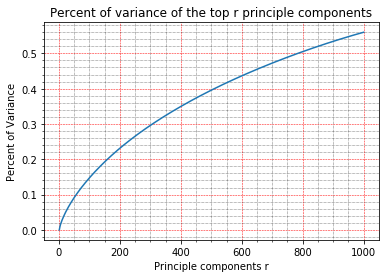

In [76]:
# Sort in ascending order
svd_ascend = np.sort(svd.explained_variance_ratio_)

# Reverse the sorted array
svd_descend = svd_ascend[::-1]

top_r = [0]*1000

for i in range(1000):
    top_r[i] = svd_descend[0:i].sum()

#plot of the percent of variance the top r principle components can retain v.s. r,
x = np.arange(1, 1001)
fig, ax = plt.subplots() #returns a tuple containing a fig and axes object(s)
ax.plot(x, top_r)
ax.set(xlabel='Principle components r', ylabel='Percent of Variance',
      title='Percent of variance of the top r principle components')
fig.savefig("Percent of variance of the top r principle components.png")

# Turn on the minor TICKS
ax.minorticks_on()

#Customize the grids
ax.grid(which='major',linestyle='--', linewidth='0.5', color='red')
ax.grid(which='minor',linestyle=':', linewidth='0.5', color='black')

Now, use the following two methods to reduce the dimension of the data. Sweep over the dimension parameters for each method, and choose one that yields better results in terms of clustering purity metrics.<br>
1. Truncated SVD/PCA: <br>
Note that one does not need to perform SVD multiple times: performing SVD with r = 1000 gives the data projected on all the top 1000 principle components, so for smaller r's, one just need to exclude the least important features. <br>
2. Non-negative matrix factorization (NMF)

In [103]:
# Plot 5 measurement scores
score = ['Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand', 'Adjusted Mutual']
def plot_measure_scores(n_components, scores, title):
    fig, ax = plt.subplots()
    for i in range(len(scores)):
        ax.plot(n_components, scores[i], label = score[i])
    ax.set(xlabel='n_components reduction (r)', ylabel ='Measure Scores for SVD', title = title)
    ax.grid()
    ax.legend() 

In [104]:
# Using SVD for dimentionality reduction
n_components = [1, 2, 3, 5, 10, 20, 50, 100, 300]
svd_homo, svd_comp, svd_v_mea, svd_adj_ran, svd_adj_mut = [], [], [], [], [] 
labels_true = conv_train_target
for r in n_components:
    labels_pred = init_kmeans.fit(svd_reduced[:,:r]).labels_
    svd_homo.append(homogeneity_score(labels_true, labels_pred))
    svd_comp.append(completeness_score(labels_true, labels_pred))
    svd_v_mea.append(v_measure_score(labels_true, labels_pred))
    svd_adj_ran.append(adjusted_rand_score(labels_true, labels_pred))
    svd_adj_mut.append(adjusted_mutual_info_score(labels_true, labels_pred))

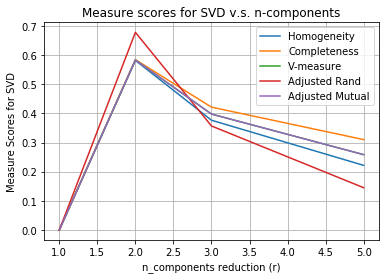

In [106]:
# First four dimension values of the principal components (n_components)
plot_measure_scores(n_components[:4], [svd_homo[:4], svd_comp[:4], svd_v_mea[:4], svd_adj_ran[:4], svd_adj_mut[:4]], 'Measure scores for SVD v.s. n-components') 

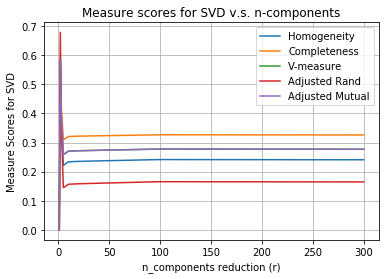

In [107]:
# Dimensions r belongs to n_components, measure scores v.s. r for SVD
plot_measure_scores(n_components, [svd_homo, svd_comp, svd_v_mea, svd_adj_ran, svd_adj_mut], 'Measure scores for SVD v.s. n-components') 

Non-monotonic behavior of the measures as r increases can be attributed to the following:<br>
1.
2.

In [114]:
# For NMF with r = 2 (dimension for reducing data to)
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X_train_tfidf)
H = model.components_
print('W:', W, 'W.shape:', W.shape)
print('H:', H, 'H.shape:', H.shape)

W: [[0.00786768 0.01721846]
 [0.00181358 0.0249825 ]
 [0.         0.04123792]
 ...
 [0.00541551 0.01374694]
 [0.0112037  0.01732916]
 [0.00885542 0.00730178]] W.shape: (7882, 2)
H: [[1.29223445e-01 1.62879018e-01 2.96748150e-03 ... 1.31748117e-04
  1.16623522e-02 1.03458953e-02]
 [6.33903731e-02 2.03265944e-02 1.53391637e-03 ... 1.02945580e-02
  0.00000000e+00 0.00000000e+00]] H.shape: (2, 27768)


In [116]:
# Using NMF for dimensionality reduction
n_components = [1, 2, 3, 5, 10, 20, 50, 100, 300]
nmf_homo, nmf_comp, nmf_v_mea, nmf_adj_ran, nmf_adj_mut = [], [], [], [], [] 
labels_true = conv_train_target

for r in n_components:
    nmf = NMF(n_components=r, init='random', random_state=0)
    X_train_tfidf_reduced_nmf = nmf.fit_transform(X_train_tfidf)
    labels_pred = init_kmeans.fit(X_train_tfidf_reduced_nmf).labels_
    
    nmf_homo.append(homogeneity_score(labels_true, labels_pred))
    nmf_comp.append(completeness_score(labels_true, labels_pred))
    nmf_v_mea.append(v_measure_score(labels_true, labels_pred))
    nmf_adj_ran.append(adjusted_rand_score(labels_true, labels_pred))
    nmf_adj_mut.append(adjusted_mutual_info_score(labels_true, labels_pred))

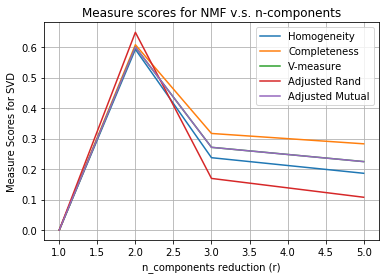

In [117]:
# First four dimension values of the principal components (n_components)
plot_measure_scores(n_components[:4], [nmf_homo[:4], nmf_comp[:4], nmf_v_mea[:4], nmf_adj_ran[:4], nmf_adj_mut[:4]], 
                    'Measure scores for NMF v.s. n-components') 

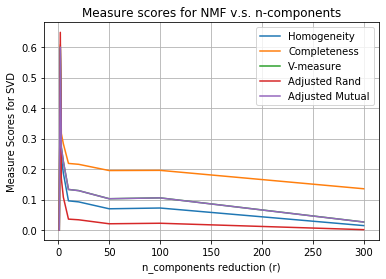

In [118]:
# Dimensions r belongs to n_components, measure scores v.s. r for NMF
plot_measure_scores(n_components, [nmf_homo, nmf_comp, nmf_v_mea, nmf_adj_ran, nmf_adj_mut], 
                    'Measure scores for NMF v.s. n-components') 

In [121]:
lb = ['homo_svd', 'comp_svd', 'v_m_svd', 'ars_svd', 'amis_svd']
def plot_measure_score(x_component, y_component, name):
    fig, ax = plt.subplots() 
    for i in range(len(y_component)):
        ax.plot(x_component,y_component[i],label =lb[i])
    ax.set(xlabel='r (n_components)', ylabel=name, title=name)
    ax.legend()
    ax.grid()
#     plt.show()
    fig.savefig(name)
n_comp = [1,2,3,5,10,20,50,100,300]

In [122]:
# NMF
homo_nmf = []
comp_nmf = []
v_m_nmf = []
ars_nmf = []
amis_nmf = []
for k in n_comp:
    nmf = NMF(n_components=k)
    X_train_reduced_tfidf_nmf = nmf.fit_transform(X_train_tfidf)
    nmf_K_means = init_kmeans.fit(X_train_reduced_tfidf_nmf)
    
    homo_nmf.append(homogeneity_score(conv_train_target, nmf_K_means.labels_))
    comp_nmf.append(completeness_score(conv_train_target, nmf_K_means.labels_))
    v_m_nmf.append(v_measure_score(conv_train_target, nmf_K_means.labels_))
    ars_nmf.append(adjusted_rand_score(conv_train_target, nmf_K_means.labels_))
    amis_nmf.append(adjusted_mutual_info_score(conv_train_target, nmf_K_means.labels_))

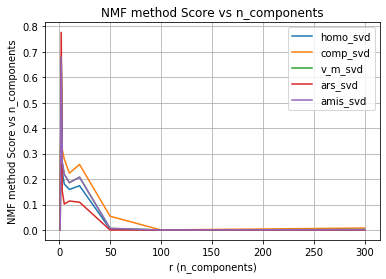

In [123]:
plot_measure_score(n_comp,[homo_nmf, comp_nmf, v_m_nmf, ars_nmf, amis_nmf], 'NMF method Score vs n_components')